# <center> EE4708: Data Analytics Laboratory </center>

# <center> Assignment 3: Naive Bayes </center>

## <center> Gautham Govind A: EE19B022 </center>

## Importing the necessary packages

In [1]:
import numpy as np
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.naive_bayes import CategoricalNB, GaussianNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
plt.rcParams.update({'font.size': 15})
plt.rcParams['figure.figsize'] = (8, 5)
warnings.filterwarnings('ignore')

## Loading the dataset

A brief look at the dataset reveals that column names are actually missing from the excel file. We add them manually:

In [3]:
column_names = ['age','workclass','fnlwgt','education','education-num','marital-status','occupation',
             'relationship','race','sex','capital-gain','capital-loss','hours-per-week','native-country','income']
df = pd.read_excel('adult.xlsx', header = None, names = column_names)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


It appears that there are no null values. 

In [5]:
df.head()

age          workclass  fnlwgt   education  education-num  \
0   39          State-gov   77516   Bachelors             13   
1   50   Self-emp-not-inc   83311   Bachelors             13   
2   38            Private  215646     HS-grad              9   
3   53            Private  234721        11th              7   
4   28            Private  338409   Bachelors             13   

        marital-status          occupation    relationship    race      sex  \
0        Never-married        Adm-clerical   Not-in-family   White     Male   
1   Married-civ-spouse     Exec-managerial         Husband   White     Male   
2             Divorced   Handlers-cleaners   Not-in-family   White     Male   
3   Married-civ-spouse   Handlers-cleaners         Husband   Black     Male   
4   Married-civ-spouse      Prof-specialty            Wife   Black   Female   

   capital-gain  capital-loss  hours-per-week  native-country  income  
0          2174             0              40   United-States   <=50K  
1             0             0              13   United-States   <=50K  
2             0             0              40   United-States   <=50K  
3             0             0              40   United-States   <=50K  
4             0             0              40            Cuba   <=50K

## Exploratory Data Analysis

We first take a quick look at the continuous variables:

In [6]:
df.describe()

age        fnlwgt  education-num  capital-gain  capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000

We make the following observations:

- We have data from the age group 17 - 90.
- Everyone has had atleast 1 year of education.
- Capital gain and loss values are 0 each for a majority of the population. This could be because a large section of the population is probably not involved in capital asset transactions.


We check how the two income classes are distributed:

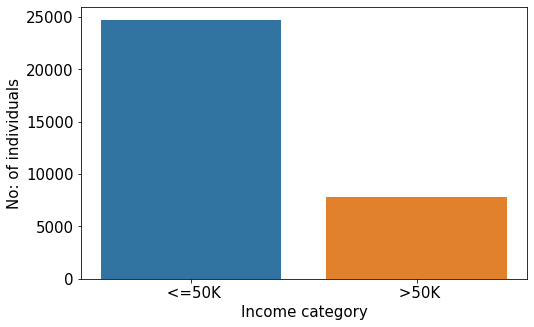

In [7]:
sns.countplot(data = df, x = 'income')
plt.xlabel('Income category')
#plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/income_dist.png", bbox_inches = "tight")

Clearly, we have a class imbalance. Hence, we will consier applying a prior to the naive bayes model.

Next, we perform Exploratory Data Analysis (EDA) on the dataset. The strategy we adopt for EDA is as follows:

For each feature, we do the following:

- We first explore how the feature itself is distributed. Eventually, the plan is to use Gaussian Naive Bayes for continuous variables and Multinomial Naive Bayes for categorical variables. So, it is necessary to verify whether the distribution of a continuous feature actually resembles a Gaussian or not.

- Next, we make appropriate plots for continuous and categorical features to explore if there is any relationship between the feature and the target variable, from a visual standpoint.

### Continuous variables

We make use of kernel density estimate (kde) plots for examining the distribution of continuous variables. KDE plots can be thought of as less cluttered versions of histogram plots.

### Correaltion plot

In [8]:
num_cols    = ['age','capital-gain','capital-loss','hours-per-week']

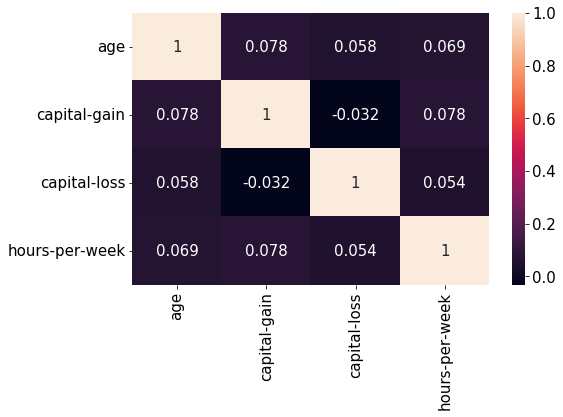

In [9]:
sns.heatmap(df[num_cols].corr(), annot = True)
plt.autoscale()
plt.savefig("Figures/cont_corr.png", bbox_inches = "tight")

### Age

Distribution:

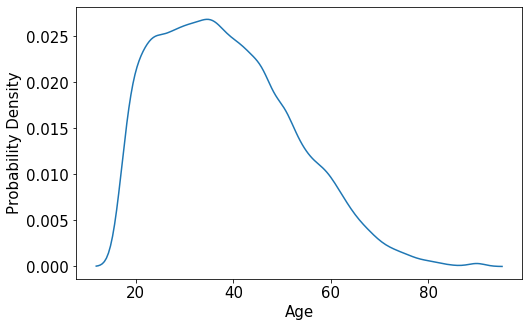

In [10]:
sns.kdeplot(data = df['age'])
plt.xlabel('Age')
plt.ylabel('Probability Density')
plt.savefig("Figures/age_kde.png")

Although the plot does resemble a gaussian, it is skewed. In an attempt to make it more like a Gaussian, we can apply the box-cox transformation:

In [11]:
gaussian_data, gaussian_lambda = stats.boxcox(df['age'])
df['age_processed'] = gaussian_data

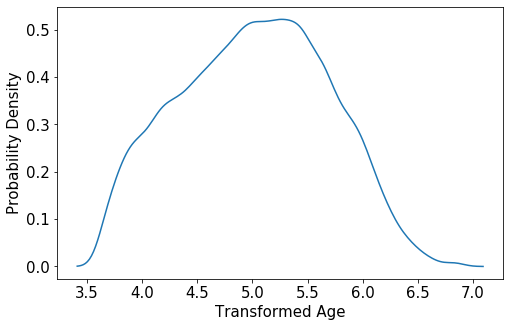

In [12]:
sns.kdeplot(data = df['age_processed'])
plt.xlabel('Transformed Age')
plt.ylabel('Probability Density')
plt.savefig("Figures/age_boxcox_kde.png")

Clearly, the distribution more closely resembles a gaussian now. We will use this transformed quantity while applying Gaussian Naive Bayes.

Distribution of age for each income category:

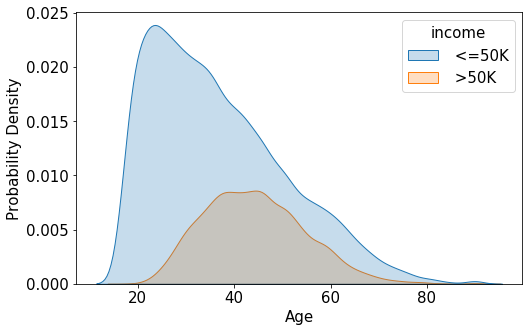

In [13]:
sns.kdeplot(data = df, x = 'age', hue = 'income', shade = True)
plt.xlabel('Age')
plt.ylabel('Probability Density')
plt.savefig("Figures/incomevsage.png")

We observe that:

- The peak for income <= 50K occurs close to the age 20. This is intuitive as we expect people in their 20s to make less income as they are probably just starting out on jobs/ businesses.
- The peak for income > 50K occurs close to the age 40. This is also intuitive as we expect most people to be at their peak earning capacity around this age. As they grow older, they move closer to retirement, possibly having an effecton their income.
- Finally, we notice that there is a greater proportion of people with income <= 50K as compared to > 50K for any given age.

### fnlwgt

Distribution:

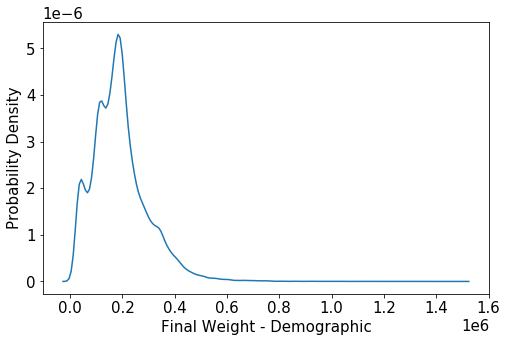

In [14]:
ax = sns.kdeplot(data = df, x = 'fnlwgt')
ax.set(xlabel = 'Final Weight - Demographic')
ax.set(ylabel = 'Probability Density')
ax.ticklabel_format(style = 'sci', scilimits = (0,0))
plt.savefig("Figures/fnlwgt_kde.png")

fnlwgt as a function of income:

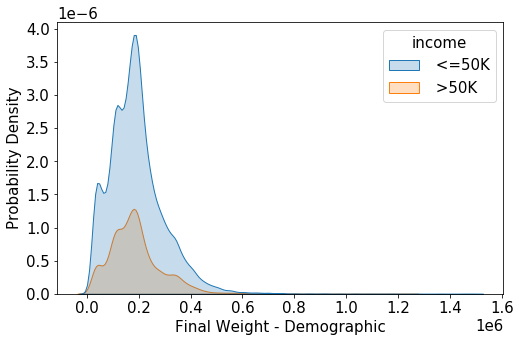

In [15]:
ax = sns.kdeplot(data = df, x = 'fnlwgt', hue = 'income', shade = True)
ax.set(xlabel = 'Final Weight - Demographic')
ax.set(ylabel = 'Probability Density')
ax.ticklabel_format(style = 'sci', scilimits = (0,0))
plt.savefig("Figures/fnlwgtvsincome.png")
plt.show()

After scouring the internet to find what this variable actually represents, the following description was found in the official dataset description:

"People with similar demographic characteristics should have similar weights.  There is one important caveat to remember about this statement.  That is that since the CPS sample is actually a collection of 51 state samples, each with its own probability of selection, the statement only applies within state."

However, we clearly have no information regarding which state an individual is from. Hence, for our purposes, we can safely discard this variable as this variable does not add any value, as long as we don't have any information regarding state.

In [16]:
df.drop('fnlwgt', axis = 1, inplace = True)

### Years of education

Distribution:

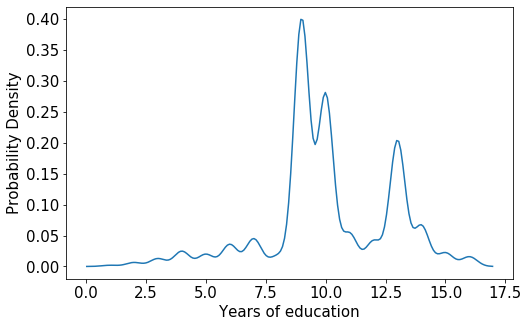

In [17]:
sns.kdeplot(data = df['education-num'])
plt.xlabel('Years of education')
plt.ylabel('Probability Density')
plt.savefig("Figures/yoe_kde.png")

We see that the distribution doesn't resemble a gaussian at all. We also note that whatever information is camptured by years of education is also captured by the 'education' column, which is categorical and hence is easier to handle with Naive Bayes.

So we drop this column and do not use it for Naive Bayes model.

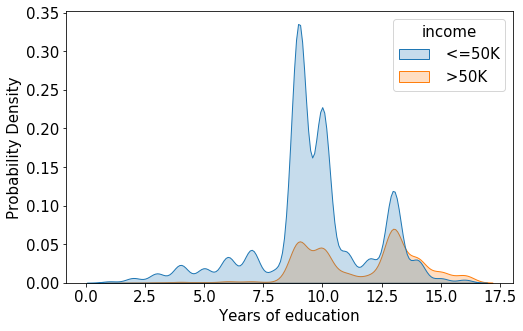

In [18]:
sns.kdeplot(data = df, x = 'education-num', hue = 'income', shade = True)
plt.xlabel('Years of education')
plt.ylabel('Probability Density')
plt.savefig("Figures/incomevyoe.png")

Generally, people who earn more tend to have invested a longer duration in education. 

In [19]:
df.drop('education-num', axis = 1, inplace = True)

### Capital Gain

Distribution:

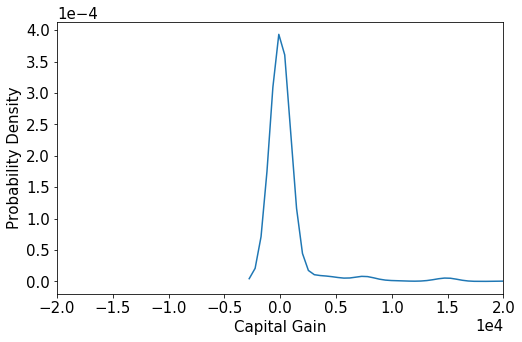

In [20]:
ax = sns.kdeplot(data = df['capital-gain'])
ax.set(xlabel = 'Capital Gain')
ax.set(xlim = (-20000, 20000))
ax.set(ylabel = 'Probability Density')
ax.ticklabel_format(style = 'sci', scilimits = (0,0))
plt.savefig("Figures/capgain_kde.png")

Although the right tail is longer than left tail, since the values are almost zero along the right tail, we consider this to be a Gaussian and hence do not apply any transform.

Distribution for each income category:

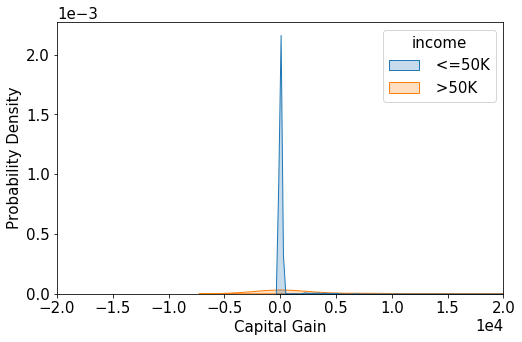

In [21]:
ax = sns.kdeplot(data = df, x = 'capital-gain', hue = 'income', shade = True)
ax.set(xlabel = 'Capital Gain')
ax.set(ylabel = 'Probability Density')
ax.ticklabel_format(style = 'sci', scilimits = (0,0))
ax.set(xlim = (-20000, 20000))
plt.savefig("Figures/capgainvsincome.png")
plt.show()

Capital gain plots don't seem to reveal any information regarding the dataset. This could be because more than 50% of the points have the value as 0 as a majority of the population do not involve in capital assest transactions.

Let us try plotting only the non-zero values to see if we can get any relationship:

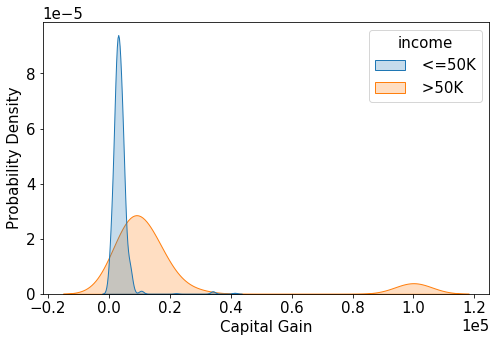

In [22]:
df_cap = df[df['capital-gain'] != 0]

ax = sns.kdeplot(data = df_cap, x = 'capital-gain', hue = 'income', shade  = True)
ax.set(xlabel = 'Capital Gain')
ax.set(ylabel = 'Probability Density')
ax.ticklabel_format(style = 'sci', scilimits = (0,0))
plt.savefig("Figures/nonzero_capgainvsincome.png")

Clearly, a higher capital gain has a higher probability density for people in the high income bracket, which makes sense intuitively.Also, on an avergae, people with income > 50K has higher capital gains as compared to people with income <= 50K.

### Capital Loss

Distribution:

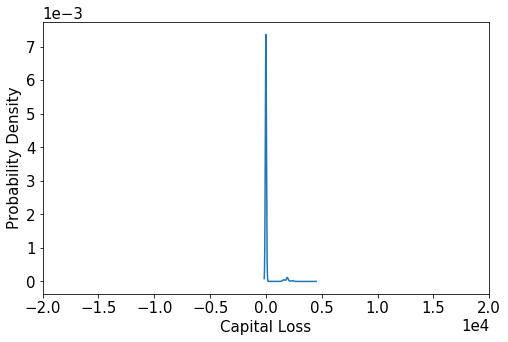

In [23]:
ax = sns.kdeplot(data = df['capital-loss'])
ax.set(xlabel = 'Capital Loss')
ax.set(xlim = (-20000, 20000))
ax.set(ylabel = 'Probability Density')
ax.ticklabel_format(style = 'sci', scilimits = (0,0))
plt.savefig("Figures/caploss_kde.png")

The situation is the same as we had with capital gain. We try plotting just the non-zero capital losses:

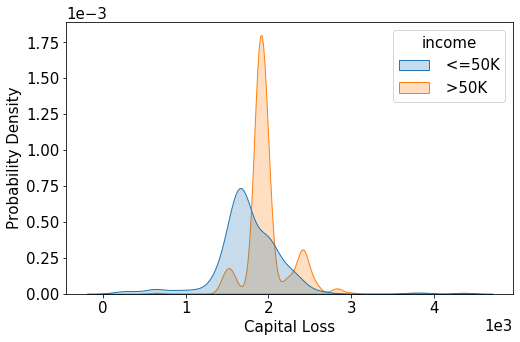

In [24]:
df_cap_loss = df[df['capital-loss'] != 0]

ax = sns.kdeplot(data = df_cap_loss, x = 'capital-loss', hue = 'income', shade  = True)
ax.set(xlabel = 'Capital Loss')
ax.set(ylabel = 'Probability Density')
ax.ticklabel_format(style = 'sci', scilimits = (0,0))
plt.savefig("Figures/nonzero_caplossvsincome.png")

Counter-intuitivey, it seems like people with higher income have higher capital losses on average! However, this could be because more you get involved in capital asset transactions, more are your chances for gain/loss. They could still be in the high income category if the gains offset losses.

### Hours per Week

Distribution:

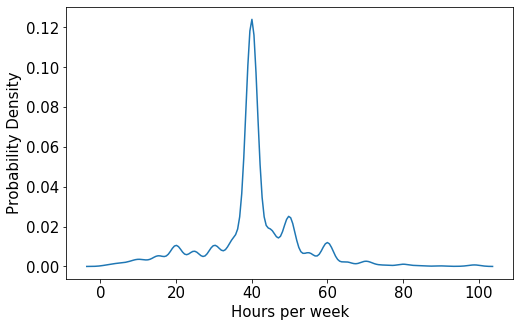

In [25]:
sns.kdeplot(data = df['hours-per-week'])
plt.xlabel('Hours per week')
plt.ylabel('Probability Density')
plt.savefig("Figures/hpw_kde.png")

The distribution is pretty close to Gaussian. We do not use any transforms.

Distribution for each income category:

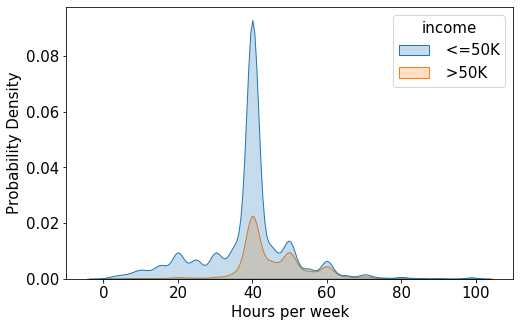

In [26]:
sns.kdeplot(data = df, x = 'hours-per-week', hue = 'income', shade = True)
plt.xlabel('Hours per week')
plt.ylabel('Probability Density')
plt.savefig("Figures/incomevshpw.png")

We make the following observations:

- Contrrary to what one would expect, it appears that working more hours does not necessarily mean your income is higher.
- However, it can be seen that a higher proportion of high income population works for more than 40 hours as compared to the lower income population.

### Categorical variables

We make use of count plots for examining the distribution of continuous variables. 


### Workclass

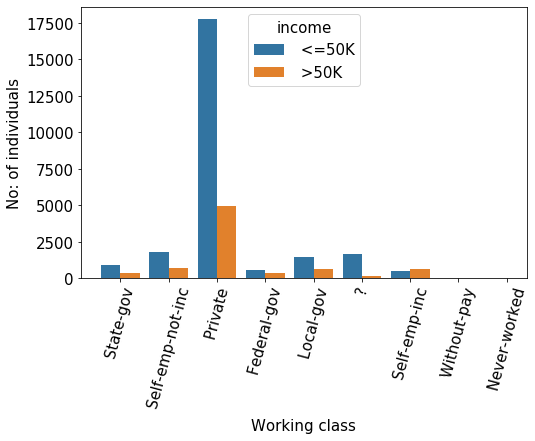

In [27]:
sns.countplot(data = df, x = 'workclass', hue = 'income')
plt.xlabel('Working class')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
#ax.set(xticks=range(len(jobs)), xticklabels=[i for i in jobs])
plt.autoscale()
plt.savefig("Figures/workclass_count.png", bbox_inches = "tight")

Observations:

- Self-employed(inc) is the only category with more individuals belonging to high income category as compared to low income category.
- Private sector has a high proportion of people from both categories.
- There are some individuals for which we do not know the working class. These are denoted by '?'.

We check how many entries have missing information regarding working class:

In [28]:
df['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' ?', ' Self-emp-inc', ' Without-pay',
       ' Never-worked'], dtype=object)

In [29]:
df[df['workclass'] == ' ?']

age workclass      education          marital-status occupation  \
27      54         ?   Some-college      Married-civ-spouse          ?   
61      32         ?        7th-8th   Married-spouse-absent          ?   
69      25         ?   Some-college           Never-married          ?   
77      67         ?           10th      Married-civ-spouse          ?   
106     17         ?           10th           Never-married          ?   
...    ...       ...            ...                     ...        ...   
32530   35         ?      Bachelors      Married-civ-spouse          ?   
32531   30         ?      Bachelors           Never-married          ?   
32539   71         ?      Doctorate      Married-civ-spouse          ?   
32541   41         ?        HS-grad               Separated          ?   
32542   72         ?        HS-grad      Married-civ-spouse          ?   

         relationship                 race      sex  capital-gain  \
27            Husband   Asian-Pac-Islander     Male             0   
61      Not-in-family                White     Male             0   
69          Own-child                White     Male             0   
77            Husband                White     Male             0   
106         Own-child                White   Female         34095   
...               ...                  ...      ...           ...   
32530            Wife                White   Female             0   
32531   Not-in-family   Asian-Pac-Islander   Female             0   
32539         Husband                White     Male             0   
32541   Not-in-family                Black   Female             0   
32542         Husband                White     Male             0   

       capital-loss  hours-per-week  native-country  income  age_processed  
27                0              60           South    >50K       5.765468  
61                0              40               ?   <=50K       4.762049  
69                0              40   United-States   <=50K       4.319551  
77                0               2   United-States   <=50K       6.206563  
106               0              32   United-States   <=50K       3.665311  
...             ...             ...             ...     ...            ...  
32530             0              55   United-States    >50K       4.927457  
32531             0              99   United-States   <=50K       4.644516  
32539             0              10   United-States    >50K       6.328000  
32541             0              32   United-States   <=50K       5.225903  
32542             0              25   United-States   <=50K       6.357474  

[1836 rows x 14 columns]

There are only 1836 such entries. Compared to the total of 32561 entries this is just 5.6%. Hence we drop these values.

In [30]:
df.replace(' ?', np.NaN,inplace = True)
df.dropna(inplace = True)

In [31]:
df['workclass'].unique()

array([' State-gov', ' Self-emp-not-inc', ' Private', ' Federal-gov',
       ' Local-gov', ' Self-emp-inc', ' Without-pay'], dtype=object)

### Education

In [32]:
df['education'].unique()

array([' Bachelors', ' HS-grad', ' 11th', ' Masters', ' 9th',
       ' Some-college', ' Assoc-acdm', ' 7th-8th', ' Doctorate',
       ' Assoc-voc', ' Prof-school', ' 5th-6th', ' 10th', ' Preschool',
       ' 12th', ' 1st-4th'], dtype=object)

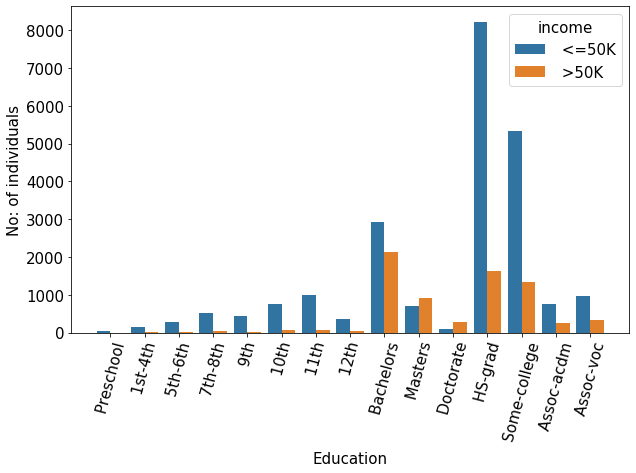

In [33]:
reordered_labesl = [' Preschool', ' 1st-4th', ' 5th-6th', ' 7th-8th', ' 9th', ' 10th', ' 11th', ' 12th', ' Bachelors', ' Masters', ' Doctorate', ' HS-grad', ' Some-college', ' Assoc-acdm', ' Assoc-voc']


plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'education', hue = 'income', order = reordered_labesl)
plt.xlabel('Education')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/education_count.png", bbox_inches = "tight")

Observations:
- Although we cannot say education directly ensures higher income, we see that the only categories with proportion of high income group more than proportion of low income group are Masters abd Doctorate groups. 
- The porportion of high income individuals is very low for people who did not attend university, again implying that education has a significant role in determining income.


Though we do have a large number of categories, we retain them as Naive Bayes is relatively computationally inexpensive and we can make use of the extra information provided by more classes with relatively less overhead.

### Marital status

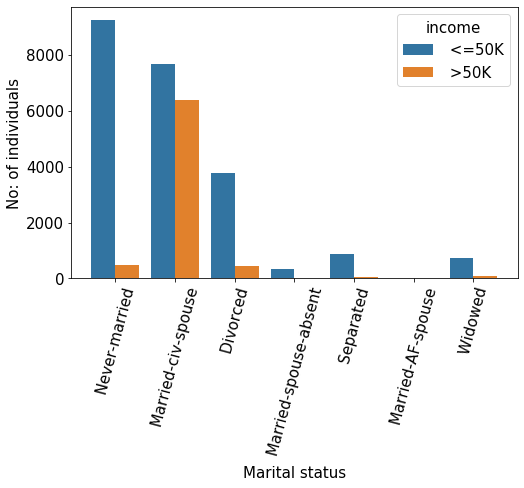

In [34]:
sns.countplot(data = df, x = 'marital-status', hue = 'income')
plt.xlabel('Marital status')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/marital_count.png", bbox_inches = "tight")

Observations:
- Married-civ-spouse is the only category which has comparable number of people belonging to both categories of income.
- For other categories, the fraction of people belonging to high income category is marginal.

### Occupation

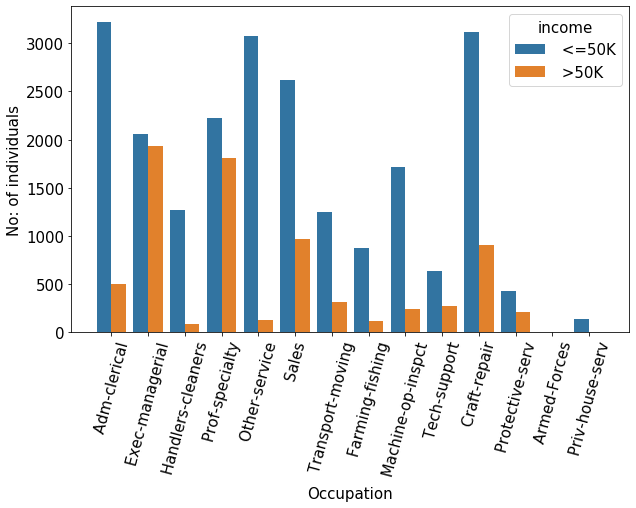

In [35]:
plt.figure(figsize = (10, 6))
sns.countplot(data = df, x = 'occupation', hue = 'income')
plt.xlabel('Occupation')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/occupation_count.png", bbox_inches = "tight")

- Managerial exectuvies and speciality professionals are likely to earn more, as we would expect intuitively. 
- People belong to other services tend to earn dispropotionately less income as compared to other groups.

### Relationship

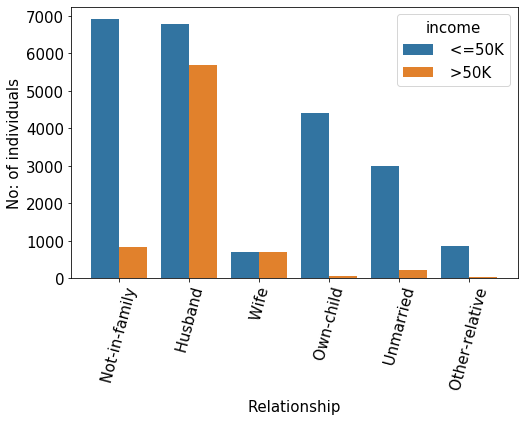

In [36]:
sns.countplot(data = df, x = 'relationship', hue = 'income')
plt.xlabel('Relationship')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/relationship_count.png", bbox_inches = "tight")

### Race

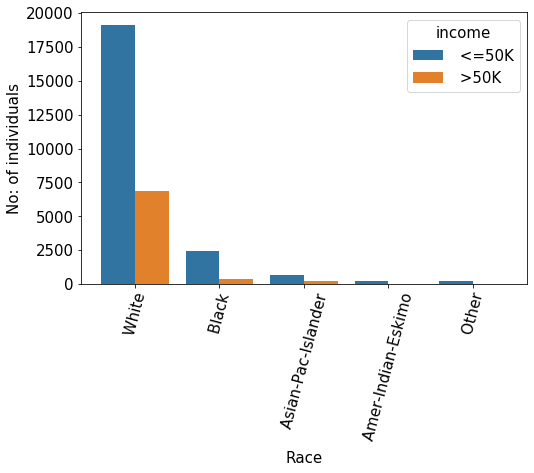

In [37]:
sns.countplot(data = df, x = 'race', hue = 'income')
plt.xlabel('Race')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/race_count.png", bbox_inches = "tight")

- It seems like the dataset is not really representative of sections other than white, as the number of individuals from other sections are disproportionately less.
- About a fourth of whites tend to earn more than 50K income.

### Sex

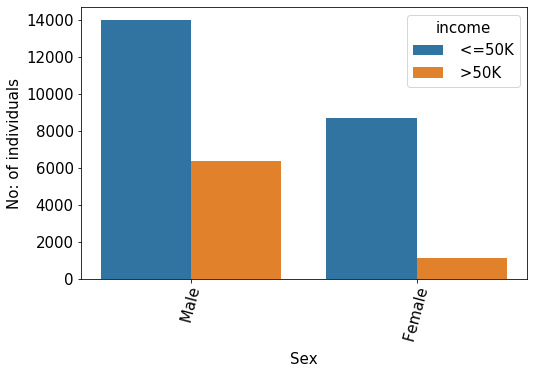

In [38]:
sns.countplot(data = df, x = 'sex', hue = 'income')
plt.xlabel('Sex')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/sex_count.png", bbox_inches = "tight")

- On an average, males have more chance to earn more than females.
- About a third of males earn more than 50k income.

### Native Country

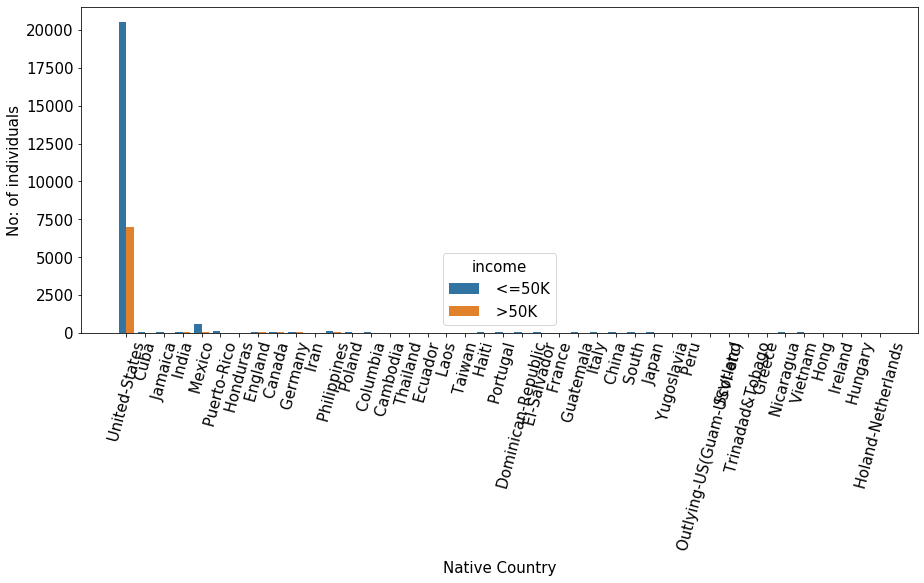

In [39]:
plt.figure(figsize = (15, 6))
sns.countplot(data = df, x = 'native-country', hue = 'income')
plt.xlabel('Native Country')
plt.xticks(rotation = 75)
plt.ylabel('No: of individuals')
plt.autoscale()
plt.savefig("Figures/native_count.png", bbox_inches = "tight")

## Preparing the dataset for Naive Bayes

Separating out numerical and cateogrical columns:

In [40]:
numerical_cols    = ['age_processed','capital-gain','capital-loss','hours-per-week']
categorical_cols  = ['workclass','education','marital-status','occupation','relationship','race','sex','native-country']

Relabelling '<=50K' and '>50K' as 0 and 1 respectively:

In [41]:
df['income'] = df['income'].map({' <=50K': 0, ' >50K': 1})

Encoding the categorical variables using sklearn's label encoder:

In [42]:
label_encoder_dict = {}

for feature in categorical_cols:
    label_encoder_dict[feature] = LabelEncoder()
    df[feature] = label_encoder_dict[feature].fit_transform(df[feature])

For gaussian naive bayes, we assume input features to be independent. For numerical variables, we check this by plotting the correlation matrix:

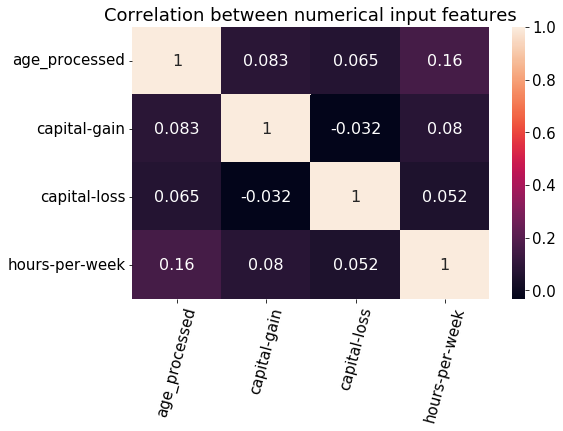

In [43]:
plt.title("Correlation between numerical input features")
sns.heatmap(df[numerical_cols].corr(), annot = True, annot_kws={"size":16})
plt.xticks(rotation = 75)
plt.yticks(rotation = 0)
plt.autoscale()
plt.savefig('Figures/num_orrelation.png', bbox_inches = "tight")

The correaltion values are very low, suggesting independence.

Finally, we spit the dataset into training, validation and test sets. We make use of stratified split so as to ensure the same proportion of income classes in all the sets.

In [44]:
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.3, random_state = 42)

for train_index, val_test_index in splitter.split(df, df['income']):
    df_train = df.iloc[train_index]
    df_val_test = df.iloc[val_test_index] 
    
df_train.reset_index(drop=True, inplace=True)
df_val_test.reset_index(drop=True, inplace = True)

In [45]:
splitter = StratifiedShuffleSplit(n_splits = 1, test_size = 0.5, random_state = 42)

for val_index, test_index in splitter.split(df_val_test, df_val_test['income']):
    df_val = df_val_test.iloc[val_index]
    df_test = df_val_test.iloc[test_index] 
    
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace = True)

In [46]:
sum(df_train['income'])/len(df_train['income'])

0.2489461469236963

In [47]:
sum(df_val['income'])/len(df_val['income'])

0.248894783377542

In [48]:
sum(df_test['income'])/len(df_test['income'])

0.24883977900552487

Clearly, the proportion is maintained.

In [49]:
X_train = df_train.drop('income',axis = 1)
y_train = df_train['income']

X_val = df_val.drop('income',axis = 1)
y_val = df_val['income']

X_test = df_test.drop('income',axis = 1)
y_test = df_test['income']

## Making the model

Essentailly, Naive Bayes is typically used either with categorical or continuous data. In this case, however we have both kinds of variables. So we build two separate models, a Gaussian NB for continuous variables as well as a multinomial NB for categorical variables. We then multiply the probabilities to arrive at the probabilities for the final mode.

We define a class which implements this:

In [50]:
class MixedNB:
    
    def __init__(self, cat_cols, num_cols, alpha = None, prior = None):
        
        if alpha:
            self.alpha = alpha
        else:
            self.alpha = 1.0
            
        self.prior = prior
        self.cat_cols = cat_cols 
        self.num_cols = num_cols
        
        self.clf1 = CategoricalNB(alpha = self.alpha, class_prior = self.prior)
        self.clf2 = GaussianNB(priors = self.prior)
     
# Fit a Gaussian NB using continuous variables and a Categorical NB using categorical variables
    def fit(self, X, y, sample_weight = None):
        self.clf1.fit(X[self.cat_cols], y)
        self.clf2.fit(X[self.num_cols], y)
        self.class_prior_ = self.clf2.class_prior_
   
# Compute overall probabilities by multiplying probabilities from each classifier
    def predict_proba(self,X):
        proba1 = self.clf1.predict_proba(X[self.cat_cols])
        proba2 = self.clf2.predict_proba(X[self.num_cols])
        proba = proba1*proba2
        proba = proba/(proba.sum(axis = 1, keepdims =1)) 
        return proba 
    
    def predict(self,X):
        proba = self.predict_proba(X)
        return np.argmax(proba,axis = 1)
    
    def score(self,X,y):
        return accuracy_score(y, self.predict(X))

### Calculating prior probabilities

In [51]:
p1 = sum(df['income'])/len(df['income'])
p0 = 1 - p1

### Model 1 (without prior)

In [52]:
prior1 = np.array([0.5,0.5])
clf1 = MixedNB(categorical_cols, numerical_cols, alpha = 1e-9, prior = prior1)
clf1.fit(X_train, y_train)
y_train_pred1 = clf1.predict(X_train)
y_val_pred1 = clf1.predict(X_val)

### Model 2 (with prior)

In [53]:
prior2 = np.array([p0, p1])
clf2 = MixedNB(categorical_cols, numerical_cols, alpha = 1e-9, prior = prior2)
clf2.fit(X_train, y_train)
y_train_pred2 = clf2.predict(X_train)
y_val_pred2 = clf2.predict(X_val)

## Evaluating the model

### Model 1 (without prior)

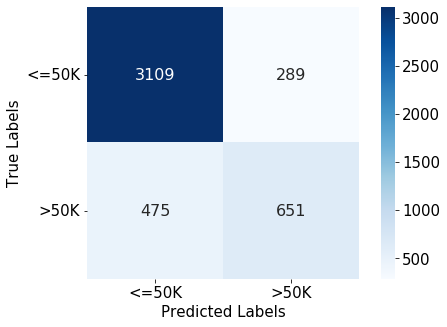

In [54]:
cm1 = confusion_matrix(y_val,y_val_pred1)
ax = plt.subplot()
sns.heatmap(cm1, square = True, annot = True, cbar=  True, cmap = 'Blues', fmt = 'g', 
           xticklabels=['<=50K','>50K'],yticklabels=['<=50K','>50K'],ax=ax,annot_kws={"size":16})
ax.set_xlabel('Predicted Labels')
plt.yticks(rotation = 0)
ax.set_ylabel('True Labels')
plt.savefig('Figures/cmwithoutprior')

In [55]:
print('Accuracy: ', accuracy_score(y_val, y_val_pred1))
print('Precision: ', precision_score(y_val, y_val_pred1))
print('Recall: ', recall_score(y_val, y_val_pred1))
print('F1 Score: ', f1_score(y_val, y_val_pred1))

Accuracy:  0.8311229000884174
Precision:  0.6925531914893617
Recall:  0.5781527531083481
F1 Score:  0.6302032913843175


### Model 2 (with prior)

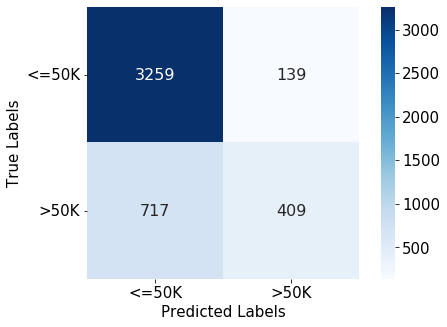

In [56]:
cm2 = confusion_matrix(y_val, y_val_pred2)
ax = plt.subplot()
sns.heatmap(cm2, square = True, annot = True, cbar=  True, cmap = 'Blues', fmt = 'g', 
           xticklabels=['<=50K','>50K'],yticklabels=['<=50K','>50K'],ax=ax,annot_kws={"size":16})
ax.set_xlabel('Predicted Labels')
plt.yticks(rotation = 0)
ax.set_ylabel('True Labels')
plt.savefig('Figures/cmwithprior')

In [57]:
print('Accuracy: ', accuracy_score(y_val, y_val_pred2))
print('Precision: ', precision_score(y_val, y_val_pred2))
print('Recall: ', recall_score(y_val, y_val_pred2))
print('F1 Score: ', f1_score(y_val, y_val_pred2))

Accuracy:  0.8107869142351901
Precision:  0.7463503649635036
Recall:  0.3632326820603908
F1 Score:  0.4886499402628435


The model with no prior (uniform prior) works better.

### ROC Curve

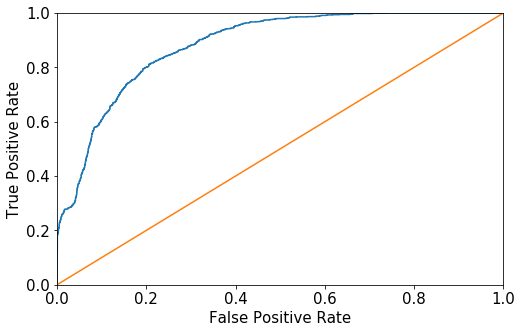

In [58]:
y_scores = clf1.predict_proba(X_test)
y_scores = y_scores[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.savefig('Figures/Roccurve.png')

In [59]:
roc_auc_score(y_test, y_scores)

0.8821184477515852

### Evaluating the performance of Gaussian and Categorical NB separately

We assume uniform prior as this turned out to perform better

#### Gaussian NB

In [60]:
clf_gauss = GaussianNB(priors = prior1)
clf_gauss.fit(X_train[numerical_cols], y_train)
y_train_pred_gauss = clf_gauss.predict(X_train[numerical_cols])
y_val_pred_gauss = clf_gauss.predict(X_val[numerical_cols])

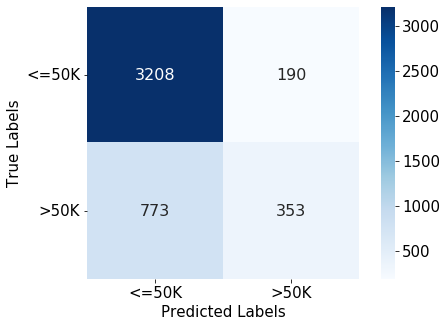

In [61]:
cm_gaussian = confusion_matrix(y_val, y_val_pred_gauss)
ax = plt.subplot()
sns.heatmap(cm_gaussian, square = True, annot = True, cbar=  True, cmap = 'Blues', fmt = 'g', 
           xticklabels=['<=50K','>50K'],yticklabels=['<=50K','>50K'],ax=ax,annot_kws={"size":16})
ax.set_xlabel('Predicted Labels')
plt.yticks(rotation = 0)
ax.set_ylabel('True Labels')
plt.savefig('Figures/cm_gauss.png')

In [62]:
print('Accuracy: ', accuracy_score(y_val, y_val_pred_gauss))
print('Precision: ', precision_score(y_val, y_val_pred_gauss))
print('Recall: ', recall_score(y_val, y_val_pred_gauss))
print('F1 Score: ', f1_score(y_val, y_val_pred_gauss))

Accuracy:  0.7871352785145889
Precision:  0.6500920810313076
Recall:  0.31349911190053287
F1 Score:  0.42300778909526665


#### Categorical NB

In [63]:
clf_cat = CategoricalNB(alpha = 1e-9 , class_prior = prior1)
clf_cat.fit(X_train[categorical_cols], y_train)
y_train_pred_cat = clf_cat.predict(X_train[categorical_cols])
y_val_pred_cat = clf_cat.predict(X_val[categorical_cols])

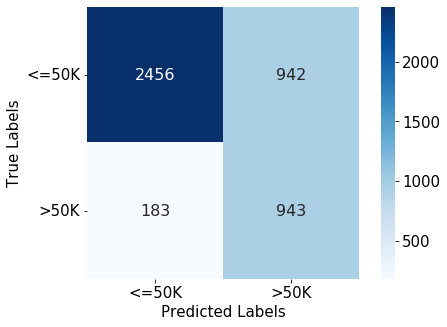

In [64]:
cm_cat = confusion_matrix(y_val, y_val_pred_cat)
ax = plt.subplot()
sns.heatmap(cm_cat, square = True, annot = True, cbar=  True, cmap = 'Blues', fmt = 'g', 
           xticklabels=['<=50K','>50K'],yticklabels=['<=50K','>50K'],ax=ax,annot_kws={"size":16})
ax.set_xlabel('Predicted Labels')
plt.yticks(rotation = 0)
ax.set_ylabel('True Labels')
plt.savefig('Figures/cm_cat.png')

In [65]:
print('Accuracy: ', accuracy_score(y_val, y_val_pred_cat))
print('Precision: ', precision_score(y_val, y_val_pred_cat))
print('Recall: ', recall_score(y_val, y_val_pred_cat))
print('F1 Score: ', f1_score(y_val, y_val_pred_cat))

Accuracy:  0.7513262599469496
Precision:  0.5002652519893899
Recall:  0.8374777975133215
F1 Score:  0.6263699767519096
